In [1]:
import os
os.chdir('/Users/mc/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')
print(os.getcwd())

import dLux as dl
import matplotlib.pyplot as plt
import alphacen
import utils
from jax import vmap
import jax.numpy as np

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "monospace"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

/Users/mc/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd
dLux: Jax is running in 32-bit, to enable 64-bit visit: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision


Creating Psf object and setting the relevant parameters

In [2]:
obj = alphacen.Psf(seed=0)
obj.pa = 90  # position angle in degrees
obj.sep = 10  # binary separation in arcseconds
obj.flux = 6.152e7 / 10 / 2  # AVERAGE flux of the two stars per frame
contrast = 3.372873  # flux contrast from V band magnitudes

Loading in the mask and creating/plotting the PSF

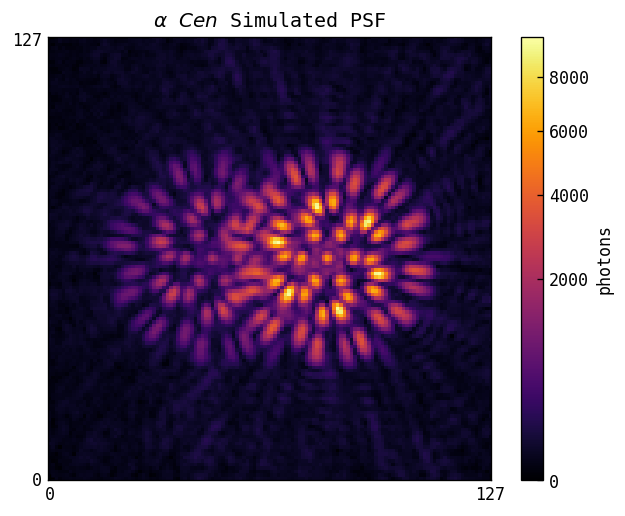

In [3]:
mask = obj.LoadMask('data/test_mask.npy')
optics, source = obj.GetInstrument(mask)
idealPSF = optics.model(source)
PSF = obj.AddNoise(idealPSF)
utils.PlotSqrtPSF(PSF, title=r'$\alpha$ $Cen$ Simulated PSF')

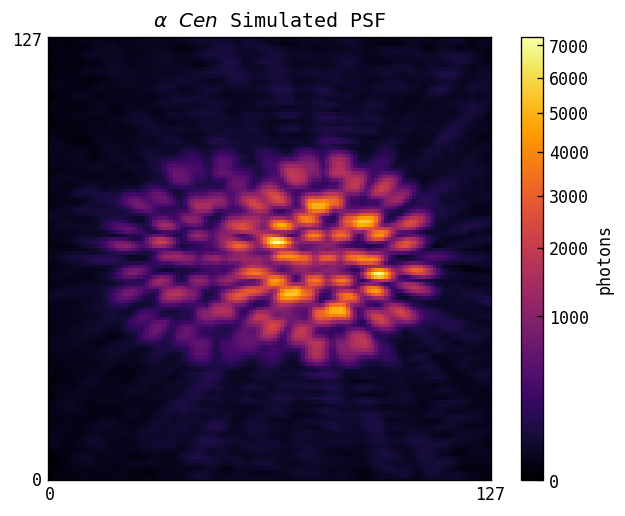

In [7]:
jitfunc = alphacen.GetJitterFunc(optics, source)
jitPSF = jitfunc(rad=5)
utils.PlotSqrtPSF(jitPSF, title=r'$\alpha$ $Cen$ Simulated PSF')

Applying linear jitter to the PSF

In [4]:
# Define the parameters of the optical system
aperture_diameter = 1.0  # meters
pixel_scale       = 1e-7 # Radians per pixel of the detector
aperture_npixels  = 256  # Number of pixels representing the wavefront
detector_npixels  = 64   # Number of pixels in the detector

# Define our Optical configuration as a list of layers
layers = [
    # Create a wavefront object
    dl.CreateWavefront(aperture_npixels, aperture_diameter),
    # Create a Circular Aperture
    dl.ApertureFactory(aperture_npixels, name='Aperture'),
    # Normalise the wavefront to unity power
    dl.NormaliseWavefront(),
    # Propagate the wavefront to the detector
    dl.AngularMFT(detector_npixels, pixel_scale, name='Propagator'),
        ]
# Create the Optics object
optics = dl.Optics(layers)

npsf = 5
pscal = optics.Propagator.pixel_scale_out

centre = np.array([0, 0]) * pscal
xs = np.linspace(-32,32, npsf) * pscal
ys = np.linspace(0,0, npsf) * pscal
positions = np.stack([xs, ys], axis=1) + centre
propagator = vmap(optics.propagate, in_axes=(None, 0))

# Propagate the wavelengths through the optics
wavelengths = 1e-9 * np.linspace(545, 645, 3)
psfs = propagator(wavelengths, positions)
psf = psfs.sum(0) / npsf

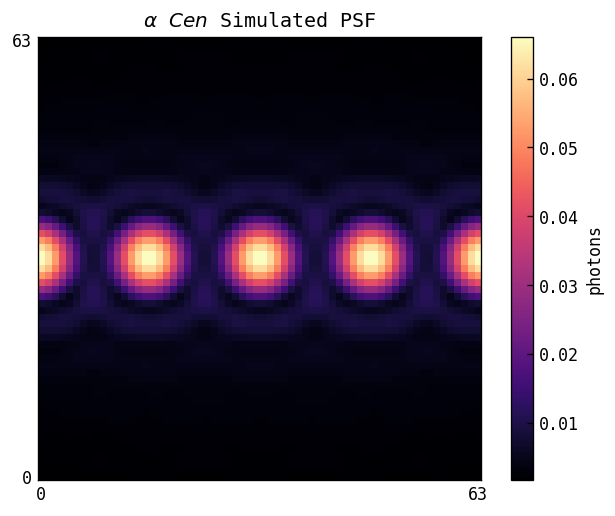

In [5]:
# plotting plot
fig, ax = plt.subplots()
c = ax.imshow(psf**.5, cmap='magma')
ax.set(title=r'$\alpha$ $Cen$ Simulated PSF',
        xticks=[0, psf.shape[0] - 1],
        yticks=[0, psf.shape[1] - 1],
        )
fig.colorbar(c, ax=ax, label ='photons')
plt.show()

Negative values in PSF. Taking absolute value.


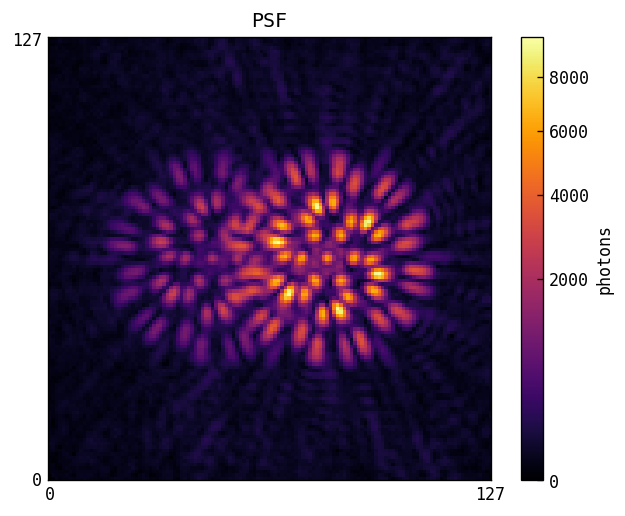

In [6]:
import utils
utils.PlotSqrtPSF(PSF, title='PSF')

In [7]:
print(PSF[np.where(PSF<0)])

[-1 -1 -1 -1 -3]
